In [1]:
import logging
from IPython.display import display

import numpy as np 
import pandas as pd
import re

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import confusion_matrix

import seaborn
import matplotlib.pyplot as plt


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# read spam assassin data set
spamAssassinRaw = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/completeSpamAssassin.csv')
spamAssassinRaw['Body']=spamAssassinRaw['Body'].astype(str)
display(spamAssassinRaw)
missingLabelValues = spamAssassinRaw['Label'].isna().sum()
emptyBodyValues = (spamAssassinRaw['Body'].values == 'empty').sum()
duplicates = spamAssassinRaw.duplicated(subset='Body',keep='first').sum()
print(f'The number of empty body values is {emptyBodyValues}')
print(f'The number of missing label values is {missingLabelValues}')
print(f'The number of duplicate values is {duplicates}')

,Unnamed: 0,Body,Label
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,3,##############################################...,1
4,4,I thought you might like these:\n1) Slim Down ...,1
...,...,...,...
6041,6041,empty,0
6042,6042,___ ___ ...,0
6043,6043,IN THIS ISSUE:01. Readers write\n02. Extension...,0
6044,6044,empty,0


The number of empty body values is 533
The number of missing label values is 0
The number of duplicate values is 753


In [4]:
# read enron data set
enronRaw = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/enronSpamSubset.csv')
enronRaw['Body']=enronRaw['Body'].astype(str)
display(enronRaw)
missingLabelValues = enronRaw['Label'].isna().sum()
emptyBodyValues = (enronRaw['Body'].values == '').sum()
duplicates = enronRaw.duplicated(subset='Body',keep='first').sum()
print(f'The number of empty body values is {emptyBodyValues}')
print(f'The number of missing label values is {missingLabelValues}')
print(f'The number of duplicate values is {duplicates}')

,Unnamed: 0.1,Unnamed: 0,Body,Label
0,2469,2469,Subject: stock promo mover : cwtd\n * * * urge...,1
1,5063,5063,Subject: are you listed in major search engine...,1
2,12564,12564,"Subject: important information thu , 30 jun 20...",1
3,2796,2796,Subject: = ? utf - 8 ? q ? bask your life with...,1
4,1468,1468,"Subject: "" bidstogo "" is places to go , things...",1
...,...,...,...,...
9995,26222,26222,"Subject: monday 22 nd oct\n louise ,\n do you ...",0
9996,18630,18630,Subject: missing bloomberg deals\n stephanie -...,0
9997,18451,18451,Subject: eops salary survey questionnaire\n we...,0
9998,21955,21955,"Subject: q 3 comparison\n hi louise ,\n i have...",0


The number of empty body values is 0
The number of missing label values is 0
The number of duplicate values is 313


In [67]:
# drop  irrelevant columns
spamAssassin = spamAssassinRaw.drop(columns=['Unnamed: 0'])
enron = enronRaw.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])
print(type(enron))
print(type(enron['Body'])) 
print(type(enron['Body'][0])) 

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'str'>


In [78]:
# combine both datasets
spam = pd.concat([spamAssassin, enron], ignore_index = True)
spam

,Body,Label
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,##############################################...,1
4,I thought you might like these:\n1) Slim Down ...,1
...,...,...
16041,"Subject: monday 22 nd oct\n louise ,\n do you ...",0
16042,Subject: missing bloomberg deals\n stephanie -...,0
16043,Subject: eops salary survey questionnaire\n we...,0
16044,"Subject: q 3 comparison\n hi louise ,\n i have...",0


In [79]:
# remove empty values and duplicates

print('before treatment')
numberOfRecords = len(spam.index)
print(f'The number of records is {numberOfRecords}')

# remove empty values
emptyBodyValues = (spam['Body'].values == 'empty').sum()
print(f'The number of empty body values is {emptyBodyValues}')
spam_no_empty = spam[spam['Body'] != 'empty']


# remove duplicates
duplicates = spam_no_empty.duplicated(subset='Body',keep='first').sum()
print(f'The number of duplicate values is {duplicates}')
spam_no_duplicates = spam_no_empty.drop_duplicates()

numberOfRecords = len(spam_no_duplicates.index)
emptyBodyValues = (spam_no_duplicates['Body'].values == 'empty').sum()
duplicates = spam_no_duplicates.duplicated(subset='Body',keep='first').sum()

print('after treatment')
print(f'The number of records is {numberOfRecords}')
print(f'The number of empty body values is {emptyBodyValues}')
print(f'The number of duplicate values is {duplicates}')


before treatment
The number of records is 16046
The number of empty body values is 533
The number of duplicate values is 534
after treatment
The number of records is 14979
The number of empty body values is 0
The number of duplicate values is 0


In [80]:
# lowering
lower = [text.lower() for text in spam_no_duplicates['Body']]
lower[0]

"\nsave up to 70% on life insurance.\nwhy spend more than you have to?life quote savings\nensuring your \n      family's financial security is very important. life quote savings makes \n      buying life insurance simple and affordable. we provide free access to the \n      very best companies and the lowest rates.life quote savings is fast, easy and \n            saves you money! let us help you get started with the best values in \n            the country on new coverage. you can save hundreds or even thousands \n            of dollars by requesting a free quote from lifequote savings. our \n            service will take you less than 5 minutes to complete. shop and \n            compare. save up to 70% on all types of life insurance! click here for your \n            free quote!protecting your family is the best investment you'll ever \n          make!\nif you are in receipt of this email \n      in error and/or wish to be removed from our list, please click here and type remove. if

In [81]:
# convert any url to URL
no_url = [re.sub(r"http\S+", "URL", text) for text in lower]
no_url[0]

"\nsave up to 70% on life insurance.\nwhy spend more than you have to?life quote savings\nensuring your \n      family's financial security is very important. life quote savings makes \n      buying life insurance simple and affordable. we provide free access to the \n      very best companies and the lowest rates.life quote savings is fast, easy and \n            saves you money! let us help you get started with the best values in \n            the country on new coverage. you can save hundreds or even thousands \n            of dollars by requesting a free quote from lifequote savings. our \n            service will take you less than 5 minutes to complete. shop and \n            compare. save up to 70% on all types of life insurance! click here for your \n            free quote!protecting your family is the best investment you'll ever \n          make!\nif you are in receipt of this email \n      in error and/or wish to be removed from our list, please click here and type remove. if

In [82]:
# remove punctuation and other non alphanumeric symbols
no_punctuation = [re.sub('[^a-zA-Z0-9 ]', '', text) for text in no_url]
no_punctuation[0]

'save up to 70 on life insurancewhy spend more than you have tolife quote savingsensuring your       familys financial security is very important life quote savings makes       buying life insurance simple and affordable we provide free access to the       very best companies and the lowest rateslife quote savings is fast easy and             saves you money let us help you get started with the best values in             the country on new coverage you can save hundreds or even thousands             of dollars by requesting a free quote from lifequote savings our             service will take you less than 5 minutes to complete shop and             compare save up to 70 on all types of life insurance click here for your             free quoteprotecting your family is the best investment youll ever           makeif you are in receipt of this email       in error andor wish to be removed from our list please click here and type remove if you       reside in any state which prohibits emai

In [83]:
# tokenizing
tokenized = [nltk.word_tokenize(text) for text in no_punctuation]
print(tokenized[0])

['save', 'up', 'to', '70', 'on', 'life', 'insurancewhy', 'spend', 'more', 'than', 'you', 'have', 'tolife', 'quote', 'savingsensuring', 'your', 'familys', 'financial', 'security', 'is', 'very', 'important', 'life', 'quote', 'savings', 'makes', 'buying', 'life', 'insurance', 'simple', 'and', 'affordable', 'we', 'provide', 'free', 'access', 'to', 'the', 'very', 'best', 'companies', 'and', 'the', 'lowest', 'rateslife', 'quote', 'savings', 'is', 'fast', 'easy', 'and', 'saves', 'you', 'money', 'let', 'us', 'help', 'you', 'get', 'started', 'with', 'the', 'best', 'values', 'in', 'the', 'country', 'on', 'new', 'coverage', 'you', 'can', 'save', 'hundreds', 'or', 'even', 'thousands', 'of', 'dollars', 'by', 'requesting', 'a', 'free', 'quote', 'from', 'lifequote', 'savings', 'our', 'service', 'will', 'take', 'you', 'less', 'than', '5', 'minutes', 'to', 'complete', 'shop', 'and', 'compare', 'save', 'up', 'to', '70', 'on', 'all', 'types', 'of', 'life', 'insurance', 'click', 'here', 'for', 'your', 'fr

In [84]:
lemma = WordNetLemmatizer()
lemmatized = [[lemma.lemmatize(w) for w in text] for text in tokenized]
print(lemmatized[0])

['save', 'up', 'to', '70', 'on', 'life', 'insurancewhy', 'spend', 'more', 'than', 'you', 'have', 'tolife', 'quote', 'savingsensuring', 'your', 'family', 'financial', 'security', 'is', 'very', 'important', 'life', 'quote', 'saving', 'make', 'buying', 'life', 'insurance', 'simple', 'and', 'affordable', 'we', 'provide', 'free', 'access', 'to', 'the', 'very', 'best', 'company', 'and', 'the', 'lowest', 'rateslife', 'quote', 'saving', 'is', 'fast', 'easy', 'and', 'save', 'you', 'money', 'let', 'u', 'help', 'you', 'get', 'started', 'with', 'the', 'best', 'value', 'in', 'the', 'country', 'on', 'new', 'coverage', 'you', 'can', 'save', 'hundred', 'or', 'even', 'thousand', 'of', 'dollar', 'by', 'requesting', 'a', 'free', 'quote', 'from', 'lifequote', 'saving', 'our', 'service', 'will', 'take', 'you', 'le', 'than', '5', 'minute', 'to', 'complete', 'shop', 'and', 'compare', 'save', 'up', 'to', '70', 'on', 'all', 'type', 'of', 'life', 'insurance', 'click', 'here', 'for', 'your', 'free', 'quoteprotec

In [85]:
without_stopwords = [[w for w in text if w not in stopwords.words('english')] for text in lemmatized]
print(without_stopwords[0])

['save', '70', 'life', 'insurancewhy', 'spend', 'tolife', 'quote', 'savingsensuring', 'family', 'financial', 'security', 'important', 'life', 'quote', 'saving', 'make', 'buying', 'life', 'insurance', 'simple', 'affordable', 'provide', 'free', 'access', 'best', 'company', 'lowest', 'rateslife', 'quote', 'saving', 'fast', 'easy', 'save', 'money', 'let', 'u', 'help', 'get', 'started', 'best', 'value', 'country', 'new', 'coverage', 'save', 'hundred', 'even', 'thousand', 'dollar', 'requesting', 'free', 'quote', 'lifequote', 'saving', 'service', 'take', 'le', '5', 'minute', 'complete', 'shop', 'compare', 'save', '70', 'type', 'life', 'insurance', 'click', 'free', 'quoteprotecting', 'family', 'best', 'investment', 'youll', 'ever', 'makeif', 'receipt', 'email', 'error', 'andor', 'wish', 'removed', 'list', 'please', 'click', 'type', 'remove', 'reside', 'state', 'prohibits', 'email', 'solicitation', 'insurance', 'please', 'disregard', 'email']


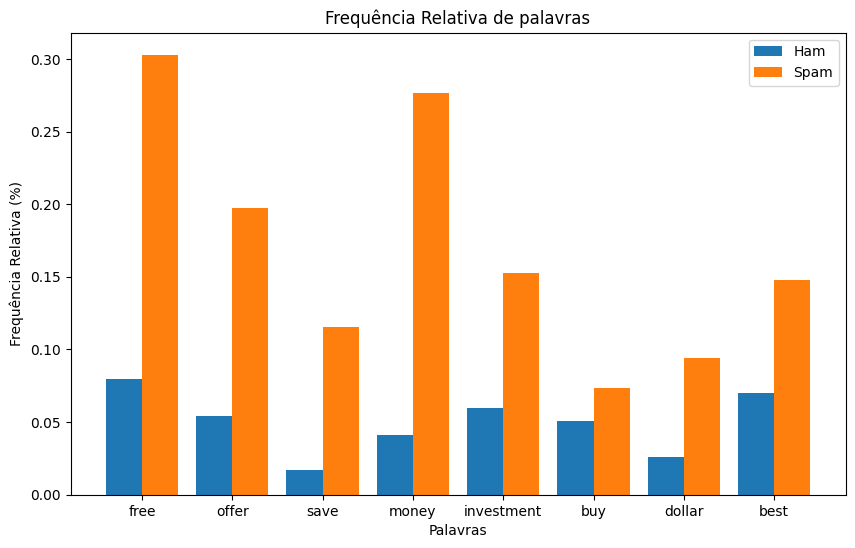

In [155]:
from collections import Counter
import matplotlib.pyplot as plt
import random

# create sample series and list
Y = spam_no_duplicates['Label']
X = without_stopwords

# filter elements of X based on Y
X_ham = [x for x, y in zip(X, Y) if y == 0]
X_spam = [x for x, y in zip(X, Y) if y == 1]

# Select random elements
X_ham = random.sample(X_ham, 5000)
X_spam = random.sample(X_spam, 5000)

# flatten the list of lists into a single list
flat_words_ham = [word for sublist in X_ham  for word in sublist]
flat_words_spam = [word for sublist in X_spam  for word in sublist]

# count the frequency of each word
word_counts_ham = Counter(flat_words_ham)
word_counts_spam = Counter(flat_words_spam)

# Total number of words
cardinality_ham = len(flat_words_ham)
cardinality_spam = len(flat_words_spam)

# Count the frequency of each word and calculate the relative frequency
relevant_words = ['free', 'offer', 'save', 'money', 'investment','buy', 'dollar','best']
ham_frequency_count = list(map(lambda x: 100 * (word_counts_ham[x]/cardinality_ham), relevant_words))
spam_frequency_count = list(map(lambda x: 100 * (word_counts_spam[x]/cardinality_spam), relevant_words))

# plot
plt.figure(figsize=(10, 6))
X_axis = np.arange(len(relevant_words))
  
plt.bar(X_axis - 0.2, ham_frequency_count, 0.4, label = 'Ham')
plt.bar(X_axis + 0.2, spam_frequency_count, 0.4, label = 'Spam')
  
plt.xticks(X_axis, relevant_words)
plt.xlabel("Palavras")
plt.ylabel("Frequência Relativa (%)")
plt.title("Frequência Relativa de palavras")
plt.legend()
plt.show()

In [96]:
vectorizer = CountVectorizer(max_features=20000)
X = vectorizer.fit_transform([' '.join(text) for text in without_stopwords]).toarray()
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [97]:
# split data set in y = labels, X = features
y = np.array(spam_no_duplicates['Label'])
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,test_size=0.2)
X_train.shape

(11983, 20000)

In [98]:
# Naive Bayes classifier
nb_model = GaussianNB()
nb_model.fit(X_train,y_train)
print("Naive Bayes Accuracy: {}".format(nb_model.score(X_test,y_test)))

Naive Bayes Accuracy: 0.9212283044058746


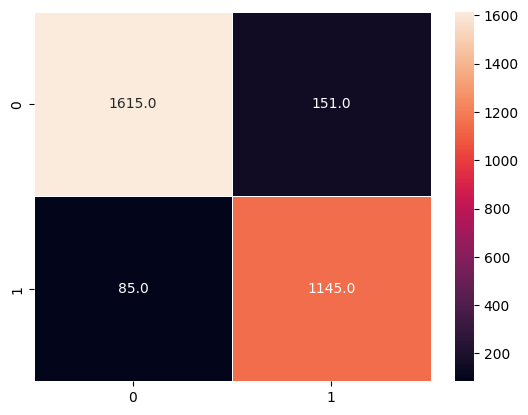

In [156]:
# Naive Bayes confusion matrix
y_pred = nb_model.predict(X_test)
conf = confusion_matrix(y_pred=y_pred,y_true=y_test)
seaborn.heatmap(conf,annot=True,fmt=".1f",linewidths=0.5)
plt.show()

In [ ]:
# logistic regression
lr_model = LogisticRegression(random_state=0)
lr_model.fit(X_train, y_train)
print("Logistic Regression Accuracy: {}".format(lr_model.score(X_test,y_test)))

Logistic Regression Accuracy: 0.9769692923898531


In [ ]:
# support vector machine algorithm
svm_model = svm.LinearSVC(max_iter=10000)
svm_model.fit(X_train,y_train)
print("Support Vector Machine Accuracy: {}".format(svm_model.score(X_test,y_test)))

Support Vector Machine Accuracy: 0.9722963951935915
